# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [59]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.neighbors import KDTree
from heapq import heappush, heappop

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [200]:
data_df = pd.read_csv("hw2_out_no_log.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("m.belyalova") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'OPTICS. (параметры - epsilon, min_pts)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [139]:
class Clustering:
    """
    Implement clustering algorithm according 
    """
    def core_distance(self, dist, eps, min_pts):
        if len(dist) - 1 < min_pts:
            return np.nan
        else:
            return dist[min_pts]
    
    def update(self, N, x, seeds, eps, min_pts, processed, reach_dist_array):
        neigh_ind, neigh_dist = N
        core_dist = self.core_distance(neigh_dist, eps, min_pts) 
        for j in range(0, neigh_ind.size):
            ind_x = neigh_ind[j]
            if not processed[ind_x]:
                new_reach_dist = max(core_dist, neigh_dist[j])
                if np.isnan(reach_dist_array[ind_x]):
                    reach_dist_array[ind_x] = new_reach_dist
                    heappush(seeds, (new_reach_dist, ind_x))
                else:
                    if new_reach_dist < reach_dist_array[ind_x]:
                        seeds[seeds.index((reach_dist_array[ind_x], ind_x))] = (new_reach_dist, ind_x)
                        reach_dist_array[ind_x] = new_reach_dist
    
    def optics(self, X, eps=0.5, min_pts=3):       
        ordered_list = []
        reachd_ord = []
        cored_ord = []
        heap_processed = []
        processed = np.zeros(len(X))       
        reach_dist_array = processed + np.nan
        core_dist_array = processed + np.nan
        #x_ind_in_ordered_list = processed + np.nan

        tree = KDTree(X, self.leaf_size)

        neigh_ind, neigh_dist = tree.query_radius(X, r=0.5, return_distance=True, sort_results=True)

        for i in range(0, len(X)):
            heappush(heap_processed, (processed[i], i))
            core_dist_array[i] = self.core_distance(neigh_dist[i], self.eps, self.min_pts)
    
        proc_flag = 0
        
        while not proc_flag or not not heap_processed:
            if not not heap_processed:
                proc_flag, i = heappop(heap_processed)
            if not proc_flag:
                processed[i] = 1
                ordered_list.append(i)
                reachd_ord.append(reach_dist_array[i])
                cored_ord.append(core_dist_array[i])
                #x_ind_in_ordered_list[i] = len(ordered_list) - 1
                if neigh_ind[i].size >= self.min_pts:
                    seeds = []
                    N = (neigh_ind[i], neigh_dist[i])
                    self.update(N, X[i], seeds, self.eps, self.min_pts, processed, reach_dist_array)
                    while not not seeds:
                        reach_dist, k = heappop(seeds)
                        NN = (neigh_ind[k], neigh_dist[k])
                        heap_processed[heap_processed.index((processed[k], k))] = (1, k)
                        processed[k] = 1
                        ordered_list.append(k)
                        reachd_ord.append(reach_dist_array[k])
                        cored_ord.append(core_dist_array[k])
                        #x_ind_in_ordered_list[k] = len(ordered_list) - 1
                        if neigh_ind[k].size >= self.min_pts:
                            self.update(NN, X[k], seeds, self.eps, self.min_pts, processed, reach_dist_array)
        #reach_dist_array[0] = core_dist_array[0]
        return (ordered_list, reachd_ord, cored_ord)
    
    def clusterize(self):
        n_clust = 0
        labels = np.zeros(self.x_len)
        for i in range(self.x_len):
            #i = self.ordered_ind[ind]
            #i = (int)(i)
            if self.reach_d[i] <= self.eps:
                labels[i] = n_clust
            elif self.core_d[i] <= self.eps:
                n_clust += 1
                labels[i] = n_clust
            #elif np.isnan(self.core_d[i]):
                #labels[i] = n_clust
        return labels.astype(int), n_clust
    
    def find_n_clust(self, nclust, maxclust=20):
        for i in range(2,maxclust):
            if i in nclust:
                return len(nclust) - 1 - nclust[::-1].index(i)
            else:
                return nclust.index(1)
    
    def __init__(self, eps=0.5, min_pts=5, leaf_size=10, **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.eps = eps
        self.min_pts = min_pts
        self.leaf_size = leaf_size
        self.labels = 0
        self.n_clusters = 0
        self.ordered_ind = 0 
        self.reach_d = 0
        self.core_d = 0
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.x_len = len(x)
        #self.x_float = x.astype(float)

        data = self.optics(x)
        self.ordered_ind, self.reach_d, self.core_d = data

        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        self.labels, self.n_clusters = self.clusterize()   
        return self.labels
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)
    
    def reach_dist(self):
        return self.reach_d
    
    def core_dist(self):
        return self.core_d
    
    def n_clusters(self):
        return self.n_clusters

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

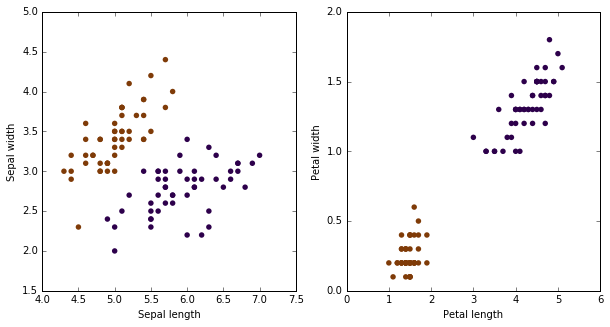

In [140]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [141]:
pred_iris = Clustering(eps=0.5, min_pts=18, leaf_size=10).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

Больше всего подходит критерий silhouette, но в он содержит ограничение на количество кластеров, поэтому не может применяться на iris и будет применен позже.

In [153]:
from sklearn.metrics.pairwise import pairwise_distances

def intra_dist(distances_row, y, i):
    mask = y == y[i]
    mask[i] = False
    if not np.any(mask):
        return 0
    a = np.mean(distances_row[mask])
    return a

def nearest_dist(distances_row, y, i):
    label = y[i]
    b = np.min([np.mean(distances_row[y == cur_label]) for cur_label in set(y) if not cur_label == label])
    return b

def silhouette(x, y):
    """
    Implement quality criterion of your choice
    """
    distances = pairwise_distances(x)
    n = y.shape[0]
    A = np.array([intra_dist(distances[i], y, i) for i in range(n)])
    B = np.array([nearest_dist(distances[i], y, i) for i in range(n)])
    sil_samples = (B - A) / np.maximum(A, B)
    return np.mean(sil_samples)

Графики зависимости adjustive rand score от параметров алгоритма eps и min_pts для тестового набора данных iris:

In [142]:
def quality(x, y):
    """
    Implement quality criterion of your choice
    """
    iris = ds.load_iris()
    y_iris = iris.target[:100]
    s = smt.adjusted_rand_score(y_iris, y[:100])
    return s

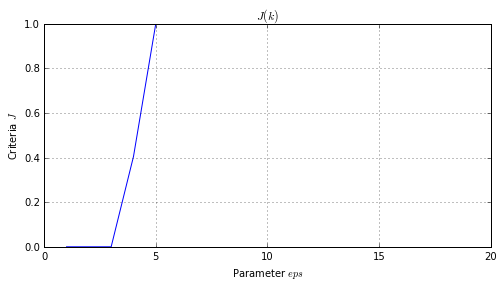

In [143]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(eps=0.1*k, min_pts=18)
    y = cls.fit_predict(x_iris)
    criteria[i] = quality(x_iris, y)
    
pl.figure(figsize=(8, 4))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Parameter $eps$")
pl.grid()
pl.show()

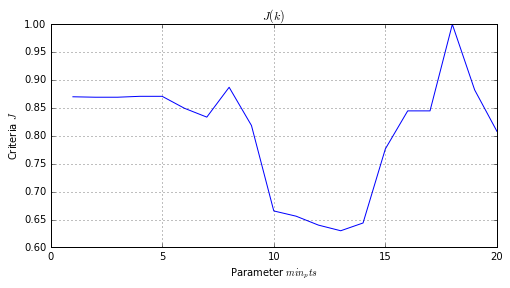

In [144]:
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(eps=0.5, min_pts=k)
    y = cls.fit_predict(x_iris)
    criteria[i] = quality(x_iris, y)
    
pl.figure(figsize=(8, 4))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Parameter $min_pts$")
pl.grid()
pl.show()

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

Далее сравнивается работа silhouette из sklearn и реализованного выше silhouette (хотя критерий silhouette тоже не очень подходит для реализованного алгоритма).

In [148]:
from sklearn.metrics import silhouette_score

In [161]:
criteria_eps = np.zeros(8)
nclust_eps = []
labels_eps = []
ks = range(5, 13)
for i, k in enumerate(ks):
    cls = Clustering(eps=0.1 + 0.01*k, min_pts=20)
    y = cls.fit_predict(x)
    labels_eps.append(y)
    nclust_eps.append(cls.n_clusters)
    if cls.n_clusters > 3:
        criteria_eps[i] = silhouette_score(x, y)
    else:
        criteria_eps[i] = np.nan

In [181]:
epsilons = []
for i, k in enumerate(ks):
    epsilons.append(0.1 + 0.01*k)

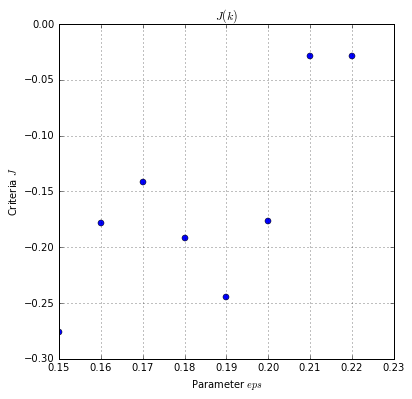

In [192]:
pl.figure(figsize=(6, 6))
pl.plot(epsilons, criteria_eps, 'o')
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Parameter $eps$")
pl.grid()
pl.show()

In [163]:
my_criteria_eps = np.zeros(8)
for i, k in enumerate(ks):
    if nclust_eps[i] > 3:
        my_criteria_eps[i] = silhouette_score(x, labels_eps[i])
    else:
        my_criteria_eps[i] = np.nan

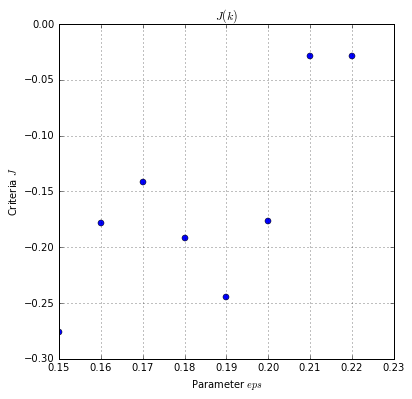

In [191]:
pl.figure(figsize=(6, 6))
pl.plot(epsilons, my_criteria_eps, 'o')
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Parameter $eps$")
pl.grid()
pl.show()

In [187]:
criteria_mp = np.zeros(20)
nclust_mp = []
labels_mp = []
for i in range(2,20):
    cls = Clustering(eps=0.21, min_pts=i)
    y = cls.fit_predict(x)
    labels_mp.append(y)
    nclust_mp.append(cls.n_clusters)
    if cls.n_clusters > 3:
        criteria_mp[i] = silhouette_score(x, y)
    else:
        criteria_mp[i] = np.nan

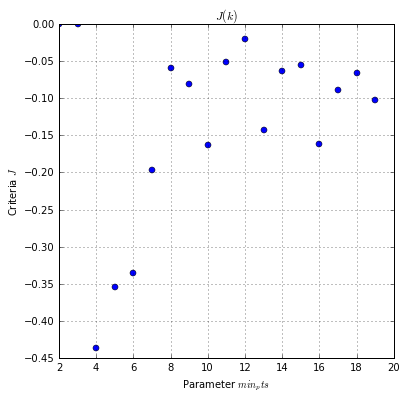

In [190]:
pl.figure(figsize=(6, 6))
pl.plot(range(2,20), criteria_mp[:len(nclust_mp)], 'o')
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Parameter $min_pts$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [19]:
k = 5

In [207]:
nclust = []
labels_y = []
for i in range(0,20):
    cls = Clustering(eps=0.1*i, min_pts=20)
    y = cls.fit_predict(x)
    labels_y.append(y)
    nclust.append(cls.n_clusters)

In [209]:
nclust = []
labels_y = []
for i in range(0,20):
    cls = Clustering(eps=0.0 + 0.01*i, min_pts=20)
    y = cls.fit_predict(x)
    labels_y.append(y)
    nclust.append(cls.n_clusters)

In [213]:
ind_k = np.arange(0,20)*0.01

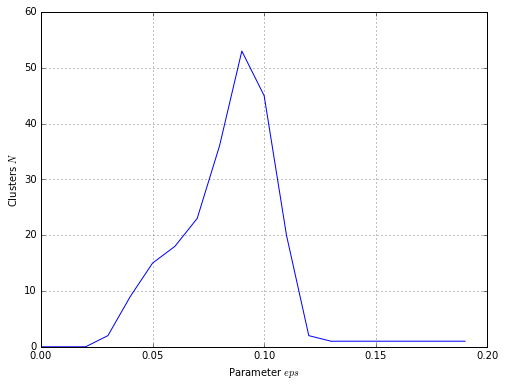

In [220]:
pl.figure(figsize=(8, 6))
pl.plot(ind_k, nclust)
pl.ylabel("Clusters $N$")
pl.xlabel("Parameter $eps$")
pl.grid()
pl.show()

In [250]:
cls = Clustering(eps=0.113, min_pts=18) 
y = cls.fit_predict(x)

In [251]:
k = cls.n_clusters

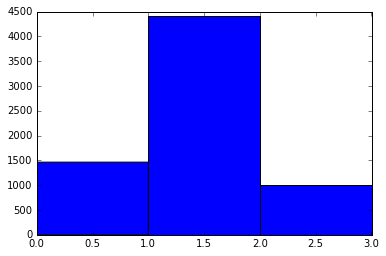

In [257]:
plt.hist(y, k)
plt.show()

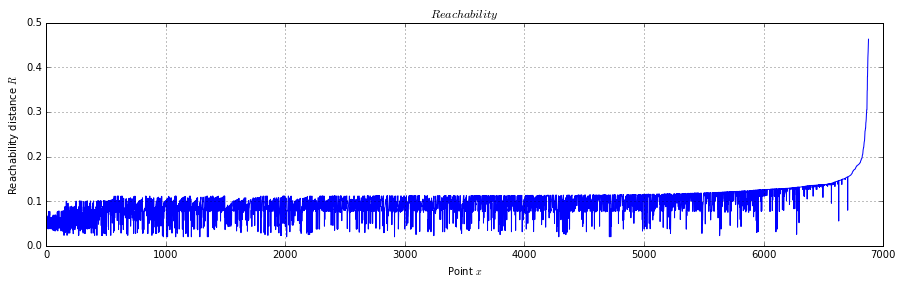

In [256]:
rd = cls.reach_dist()
pl.figure(figsize=(15, 4))
pl.plot(rd)
pl.title("$Reachability$")
pl.ylabel("Reachability distance $R$")
pl.xlabel("Point $x$")
pl.grid()
pl.show()

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 6882
[t-SNE] Computed conditional probabilities for sample 2000 / 6882
[t-SNE] Computed conditional probabilities for sample 3000 / 6882
[t-SNE] Computed conditional probabilities for sample 4000 / 6882
[t-SNE] Computed conditional probabilities for sample 5000 / 6882
[t-SNE] Computed conditional probabilities for sample 6000 / 6882
[t-SNE] Computed conditional probabilities for sample 6882 / 6882
[t-SNE] Mean sigma: 0.061422
[t-SNE] Error after 100 iterations with early exaggeration: 1.583063
[t-SNE] Error after 350 iterations: 1.456929


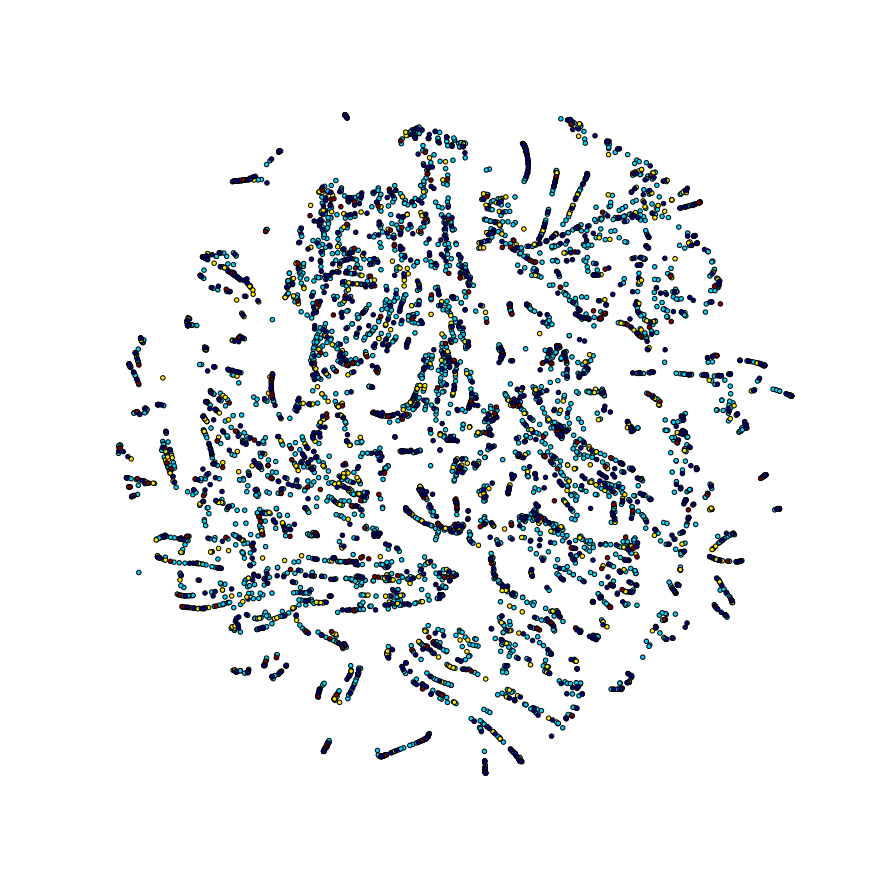

In [254]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

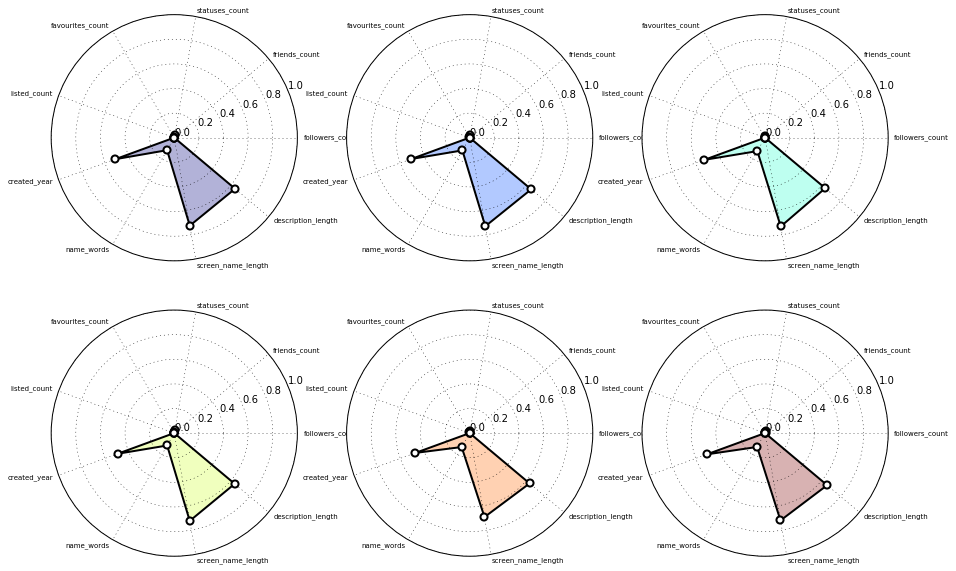

In [265]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.